<a href="https://colab.research.google.com/github/sahasraa178/c-program/blob/main/Team17_Maths_endsem_project_code.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
#@title Install dependencies
!pip install -q numpy matplotlib seaborn

#@title Imports
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

sns.set(style="whitegrid")


In [ ]:
#@title Irrigation MDP environment
class IrrigationMDPEnv:
    """
    Discrete MDP environment for irrigation scheduling.
    States: 0=Dry, 1=Moist, 2=Wet
    Actions: 0=Wait, 1=Irrigate

    Transition matrices P[a][s, s'] and rewards R[s, a].
    """

    def __init__(self, gamma=0.9, seed=42):
        self.states = np.array([0, 1, 2])
        self.actions = np.array([0, 1])  # 0=Wait, 1=Irrigate
        self.nS, self.nA = len(self.states), len(self.actions)
        rng = np.random.default_rng(seed)

        # Transition matrices per action (rows sum to 1)
        self.P = {
            0: np.array([
                [0.60, 0.30, 0.10],  # from Dry if Wait
                [0.20, 0.60, 0.20],  # from Moist if Wait
                [0.10, 0.30, 0.60],  # from Wet if Wait
            ]),
            1: np.array([
                [0.00, 0.70, 0.30],  # from Dry if Irrigate
                [0.00, 0.40, 0.60],  # from Moist if Irrigate
                [0.00, 0.20, 0.80],  # from Wet if Irrigate
            ])
        }

        # Rewards: crop health vs. water cost
        self.R = np.zeros((self.nS, self.nA), dtype=float)
        self.R[0, 0] = -5  # Dry, Wait
        self.R[0, 1] = -2  # Dry, Irrigate
        self.R[1, 0] = +5  # Moist, Wait
        self.R[1, 1] = +3  # Moist, Irrigate
        self.R[2, 0] = +2  # Wet, Wait
        self.R[2, 1] = -4  # Wet, Irrigate

        self.gamma = gamma
        self.rng = rng
        self.state = 1  # start at Moist by default

    def reset(self, state=None):
        self.state = self.rng.choice(self.states) if state is None else state
        return self.state

    def step(self, action):
        probs = self.P[action][self.state]
        next_state = self.rng.choice(self.states, p=probs)
        reward = self.R[self.state, action]
        self.state = next_state
        done = False
        return next_state, reward, done, {}


In [ ]:
#@title Value iteration
def value_iteration(env: IrrigationMDPEnv, tol=1e-8, max_iter=1000):
    V = np.zeros(env.nS)
    for it in range(max_iter):
        V_old = V.copy()
        for s in range(env.nS):
            q_vals = []
            for a in range(env.nA):
                q = env.R[s, a] + env.gamma * np.dot(env.P[a][s], V_old)
                q_vals.append(q)
            V[s] = np.max(q_vals)
        if np.max(np.abs(V - V_old)) < tol:
            break

    policy = np.zeros(env.nS, dtype=int)
    for s in range(env.nS):
        q_vals = [env.R[s, a] + env.gamma * np.dot(env.P[a][s], V) for a in range(env.nA)]
        policy[s] = int(np.argmax(q_vals))
    return V, policy

env = IrrigationMDPEnv(gamma=0.9, seed=123)
V_opt, policy_opt = value_iteration(env)
print("Optimal values:", V_opt)
print("Optimal policy (0=Wait,1=Irrigate):", policy_opt)


Optimal values: [25.71334985 31.93632901 28.12393546]
Optimal policy (0=Wait,1=Irrigate): [1 0 0]


In [ ]:
#@title Policy iteration
def policy_evaluation(env, policy, tol=1e-10, max_iter=10000):
    V = np.zeros(env.nS)
    for _ in range(max_iter):
        V_old = V.copy()
        for s in range(env.nS):
            a = policy[s]
            V[s] = env.R[s, a] + env.gamma * np.dot(env.P[a][s], V_old)
        if np.max(np.abs(V - V_old)) < tol:
            break
    return V

def policy_improvement(env, V):
    policy = np.zeros(env.nS, dtype=int)
    for s in range(env.nS):
        q_vals = [env.R[s, a] + env.gamma * np.dot(env.P[a][s], V) for a in range(env.nA)]
        policy[s] = int(np.argmax(q_vals))
    return policy

def policy_iteration(env: IrrigationMDPEnv):
    policy = np.zeros(env.nS, dtype=int)  # start with all Wait
    while True:
        V = policy_evaluation(env, policy)
        new_policy = policy_improvement(env, V)
        if np.array_equal(new_policy, policy):
            return V, policy
        policy = new_policy

V_pi, policy_pi = policy_iteration(env)
print("Policy iteration values:", V_pi)
print("Policy iteration policy:", policy_pi)


Policy iteration values: [25.71334993 31.9363291  28.12393554]
Policy iteration policy: [1 0 0]


In [ ]:
#@title Plotting functions
def plot_value_function(V, labels):
    plt.figure(figsize=(6, 3))
    plt.bar(labels, V, color="#4c72b0")
    plt.ylabel("V(s)")
    plt.title("Value function")
    plt.tight_layout()
    plt.show()

def plot_policy(policy, labels):
    # 0=Wait, 1=Irrigate
    action_names = {0: "Wait", 1: "Irrigate"}
    actions_str = [action_names[a] for a in policy]
    plt.figure(figsize=(6, 2.5))
    sns.heatmap(np.array(policy).reshape(1, -1),
                annot=np.array(actions_str).reshape(1, -1),
                fmt="", cbar=False,
                xticklabels=labels, yticklabels=["Optimal action"])
    plt.title("Policy heatmap")
    plt.tight_layout()
    plt.show()

def plot_trajectories(trajectories, labels, n_show=10):
    plt.figure(figsize=(7, 3))
    for traj in trajectories[:n_show]:
        plt.plot(traj, alpha=0.6)
    plt.yticks([0,1,2], labels)
    plt.xlabel("Time step")
    plt.ylabel("Soil moisture state")
    plt.title("Episode trajectories")
    plt.tight_layout()
    plt.show()

def plot_rewards_box(reward_lists, labels):
    plt.figure(figsize=(6, 3))
    sns.boxplot(data=reward_lists)
    plt.xticks(range(len(labels)), labels)
    plt.ylabel("Episode total reward")
    plt.title("Reward comparison")
    plt.tight_layout()
    plt.show()


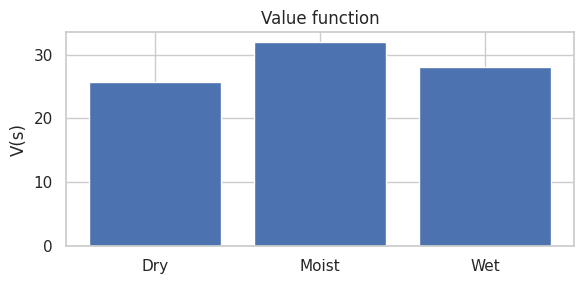

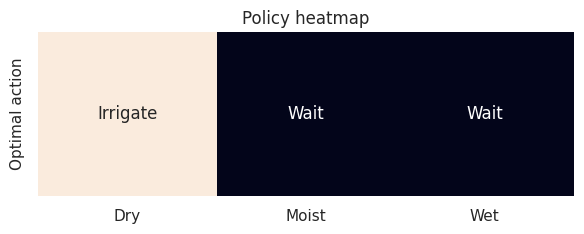

In [ ]:
#@title Visualize value function and policy (value iteration)
labels = ["Dry", "Moist", "Wet"]
plot_value_function(V_opt, labels)
plot_policy(policy_opt, labels)


Optimal policy: mean reward=178.53, std=18.52
Naive policy:   mean reward=179.53, std=18.89


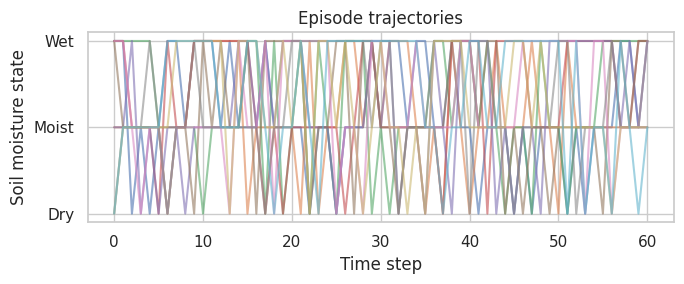

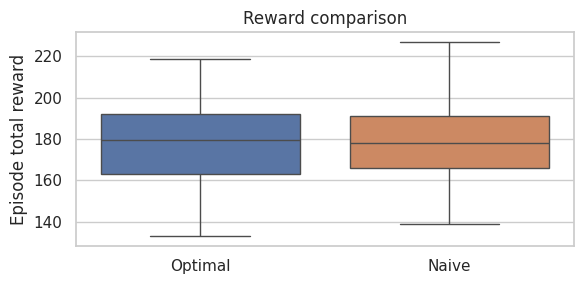

In [ ]:
#@title Simulate episodes
def run_episodes(env, policy, episodes=40, horizon=60, seed=123):
    rng = np.random.default_rng(seed)
    trajectories, rewards = [], []
    for _ in range(episodes):
        s = env.reset(state=rng.choice([0,1,2]))
        traj, ep_rewards = [s], []
        for _ in range(horizon):
            a = policy[s]
            s, r, done, _ = env.step(a)
            traj.append(s)
            ep_rewards.append(r)
        trajectories.append(traj)
        rewards.append(np.sum(ep_rewards))
    return trajectories, np.array(rewards)

# Optimal vs. Naive baseline
policy_naive = np.array([1, 0, 0])  # Irrigate when Dry; Wait otherwise
trajs_opt, rews_opt = run_episodes(env, policy_opt, episodes=40, horizon=60, seed=7)
trajs_nai, rews_nai = run_episodes(env, policy_naive, episodes=40, horizon=60, seed=7)

print(f"Optimal policy: mean reward={rews_opt.mean():.2f}, std={rews_opt.std():.2f}")
print(f"Naive policy:   mean reward={rews_nai.mean():.2f}, std={rews_nai.std():.2f}")

# Plots
plot_trajectories(trajs_opt, labels)
plot_rewards_box([rews_opt, rews_nai], labels=["Optimal", "Naive"])


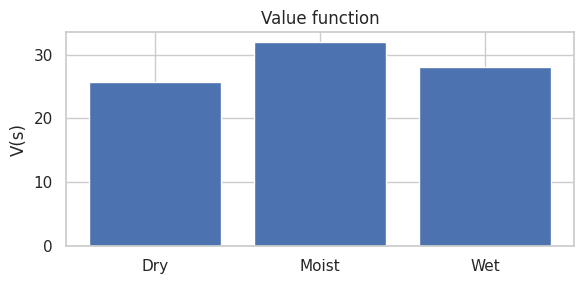

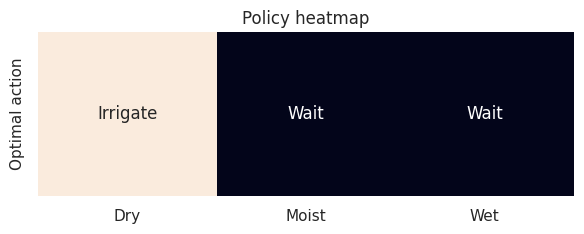

In [ ]:
#@title Compare solvers
plot_value_function(V_pi, labels)
plot_policy(policy_pi, labels)


In [ ]:
class IrrigationMDPEnv:
    ...


In [ ]:
import numpy as np


In [ ]:
def value_iteration(env, tol=1e-8, max_iter=1000):
    V = np.zeros(env.nS)
    for it in range(max_iter):
        V_old = V.copy()
        for s in range(env.nS):
            q_vals = []
            for a in range(env.nA):
                q = env.R[s, a] + env.gamma * np.dot(env.P[a][s], V_old)
                q_vals.append(q)
            V[s] = np.max(q_vals)
        if np.max(np.abs(V - V_old)) < tol:
            break

    policy = np.zeros(env.nS, dtype=int)
    for s in range(env.nS):
        q_vals = [env.R[s, a] + env.gamma * np.dot(env.P[a][s], V) for a in range(env.nA)]
        policy[s] = int(np.argmax(q_vals))
    return V, policy

In [ ]:
def value_iteration(env, tol=1e-8, max_iter=1000):
    V = np.zeros(env.nS)
    for it in range(max_iter):
        V_old = V.copy()
        for s in range(env.nS):
            q_vals = []
            for a in range(env.nA):
                q = env.R[s, a] + env.gamma * np.dot(env.P[a][s], V_old)
                q_vals.append(q)
            V[s] = np.max(q_vals)
        if np.max(np.abs(V - V_old)) < tol:
            break

    policy = np.zeros(env.nS, dtype=int)
    for s in range(env.nS):
        q_vals = [env.R[s, a] + env.gamma * np.dot(env.P[a][s], V) for a in range(env.nA)]
        policy[s] = int(np.argmax(q_vals))
    return V, policy


In [ ]:
import numpy as np

class IrrigationMDPEnv:
    def __init__(self, gamma=0.9, seed=42):
        self.gamma = gamma
        self.rng = np.random.default_rng(seed)

        self.nS = 3  # Dry, Moist, Wet
        self.nA = 2  # Irrigate, Wait
        self.states = [0, 1, 2]  # Dry, Moist, Wet
        self.states = [0, 1, 2]

        # Transition probabilities
        self.P = {
            0: [  # Irrigate
                [0.0, 0.3, 0.7],  # Dry
                [0.0, 0.2, 0.8],  # Moist
                [0.0, 0.1, 0.9],  # Wet
            ],
            1: [  # Wait
                [0.6, 0.3, 0.1],  # Dry
                [0.3, 0.4, 0.3],  # Moist
                [0.1, 0.3, 0.6],  # Wet
            ],
        }

        # Reward matrix
        self.R = np.array([
            [-2, 0],   # Dry
            [5, 2],    # Moist
            [3, 4],    # Wet
        ])
        self.state = 1 # Default initial state

    def reset(self, state=None):
        if state is None:
            self.state = self.rng.choice([0, 1, 2])  # Dry, Moist, Wet
        else:
            self.state = state
        return self.state

    def step(self, action):
        probs = self.P[action][self.state]
        next_state = self.rng.choice(self.states, p=probs)
        reward = self.R[self.state, action]
        self.state = next_state
        done = False
        return next_state, reward, done, {}


In [ ]:
#@title 🌾 Irrigation MDP Interactive Simulation (GUI)

try:
    IrrigationMDPEnv
except NameError:
    print("⚠️ Please run the cell that defines IrrigationMDPEnv before running this GUI.")

import ipywidgets as widgets
from IPython.display import display, clear_output

# === GUI widgets ===
gamma_slider = widgets.FloatSlider(value=0.9, min=0.5, max=0.99, step=0.01, description='Discount γ:')
episodes_slider = widgets.IntSlider(value=30, min=10, max=100, step=10, description='Episodes:')
horizon_slider = widgets.IntSlider(value=50, min=20, max=100, step=10, description='Horizon:')
policy_dropdown = widgets.Dropdown(options=['optimal', 'naive'], value='optimal', description='Policy:')

run_button = widgets.Button(description='Run Simulation', button_style='success')
output_area = widgets.Output()
9
# === Callback ===
def on_run_clicked(b):
    with output_area:
        clear_output()
        # ✅ FIXED: correct class name and constructor
        env = IrrigationMDPEnv(gamma=gamma_slider.value, seed=123)

        # Select policy
        if policy_dropdown.value == 'optimal':
            V, policy = value_iteration(env)
        else:
            policy = np.array([1, 0, 0])  # naive: irrigate only when dry
            V = policy_evaluation(env, policy)

        # Run simulation
        trajs, rews = run_episodes(env, policy,
                                   episodes=episodes_slider.value,
                                   horizon=horizon_slider.value,
                                   seed=42)

        # Display results
        print(f"Policy: {policy_dropdown.value}")
        print(f"Mean reward: {np.mean(rews):.2f}, Std: {np.std(rews):.2f}")
        plot_policy(policy, labels=["Dry", "Moist", "Wet"])
        plot_value_function(V, labels=["Dry", "Moist", "Wet"])
        plot_trajectories(trajs, labels=["Dry", "Moist", "Wet"])
        plot_rewards_box([rews], labels=[policy_dropdown.value])

run_button.on_click(on_run_clicked)

# === Display GUI ===
display(gamma_slider, episodes_slider, horizon_slider, policy_dropdown, run_button, output_area)


FloatSlider(value=0.9, description='Discount γ:', max=0.99, min=0.5, step=0.01)

IntSlider(value=30, description='Episodes:', min=10, step=10)

IntSlider(value=50, description='Horizon:', min=20, step=10)

Dropdown(description='Policy:', options=('optimal', 'naive'), value='optimal')

Button(button_style='success', description='Run Simulation', style=ButtonStyle())

Output()

In [ ]:
!pip install streamlit pyngrok --quiet


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.2/10.2 MB 31.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.9/6.9 MB 30.3 MB/s eta 0:00:00


In [ ]:
%%writefile app.py
import streamlit as st
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

class IrrigationMDPEnv:
    def __init__(self, gamma=0.9, seed=42):
        self.gamma = gamma
        self.rng = np.random.default_rng(seed)
        self.nS = 3
        self.nA = 2
        self.states = [0, 1, 2]
        self.P = {
            0: [[0.0, 0.3, 0.7], [0.0, 0.2, 0.8], [0.0, 0.1, 0.9]],
            1: [[0.6, 0.3, 0.1], [0.3, 0.4, 0.3], [0.1, 0.3, 0.6]],
        }
        self.R = np.array([[-2, 0], [5, 2], [3, 4]])

    def reset(self, state=None):
        if state is None:
            state = self.rng.choice(self.states)
        self.state = state
        return self.state

    def step(self, action):
        probs = self.P[action][self.state]
        next_state = self.rng.choice(self.states, p=probs)
        reward = self.R[self.state, action]
        self.state = next_state
        return next_state, reward

def value_iteration(env, tol=1e-8, max_iter=1000):
    V = np.zeros(env.nS)
    for _ in range(max_iter):
        V_old = V.copy()
        for s in range(env.nS):
            q_vals = [env.R[s, a] + env.gamma * np.dot(env.P[a][s], V_old) for a in range(env.nA)]
            V[s] = np.max(q_vals)
        if np.max(np.abs(V - V_old)) < tol:
            break
    policy = np.zeros(env.nS, dtype=int)
    for s in range(env.nS):
        q_vals = [env.R[s, a] + env.gamma * np.dot(env.P[a][s], V) for a in range(env.nA)]
        policy[s] = int(np.argmax(q_vals))
    return V, policy

def policy_evaluation(env, policy, tol=1e-8, max_iter=1000):
    V = np.zeros(env.nS)
    for _ in range(max_iter):
        V_old = V.copy()
        for s in range(env.nS):
            a = policy[s]
            V[s] = env.R[s, a] + env.gamma * np.dot(env.P[a][s], V_old)
        if np.max(np.abs(V - V_old)) < tol:
            break
    return V

def run_episodes(env, policy, episodes=30, horizon=50, seed=42):
    rng = np.random.default_rng(seed)
    trajectories, rewards = [], []
    for _ in range(episodes):
        s = env.reset(state=rng.choice(env.states))
        traj, ep_rewards = [s], []
        for _ in range(horizon):
            a = policy[s]
            s, r = env.step(a)
            traj.append(s)
            ep_rewards.append(r)
        trajectories.append(traj)
        rewards.append(np.sum(ep_rewards))
    return trajectories, rewards

def plot_policy(policy, labels):
    fig, ax = plt.subplots()
    sns.heatmap([policy], annot=True, cmap="YlGnBu", xticklabels=labels, yticklabels=["Optimal action"], ax=ax)
    st.pyplot(fig)

def plot_value_function(V, labels):
    fig, ax = plt.subplots()
    sns.heatmap([V], annot=True, cmap="YlOrBr", xticklabels=labels, yticklabels=["Value"], ax=ax)
    st.pyplot(fig)

def plot_trajectories(trajs, labels):
    fig, ax = plt.subplots()
    for traj in trajs:
        ax.plot(traj, alpha=0.5)
    ax.set_yticks([0, 1, 2])
    ax.set_yticklabels(labels)
    ax.set_title("State trajectories")
    ax.set_xlabel("Time step")
    ax.set_ylabel("State")
    st.pyplot(fig)

def plot_rewards_box(reward_lists, labels):
    fig, ax = plt.subplots()
    sns.boxplot(data=reward_lists, ax=ax)
    ax.set_xticklabels(labels)
    ax.set_title("Reward distribution")
    ax.set_ylabel("Total reward")
    st.pyplot(fig)

# === Streamlit UI ===
st.title("🌾 Irrigation MDP Simulation")

gamma = st.slider("Discount γ", 0.5, 0.99, 0.9, 0.01)
episodes = st.slider("Episodes", 10, 100, 30, 10)
horizon = st.slider("Horizon", 20, 100, 50, 10)
policy_type = st.selectbox("Policy", ["optimal", "naive"])

if st.button("Run Simulation"):
    env = IrrigationMDPEnv(gamma=gamma, seed=123)
    if policy_type == "optimal":
        V, policy = value_iteration(env)
    else:
        policy = np.array([1, 0, 0])
        V = policy_evaluation(env, policy)
    trajs, rews = run_episodes(env, policy, episodes=episodes, horizon=horizon, seed=42)
    st.write(f"**Policy:** {policy_type}")
    st.write(f"**Mean reward:** {np.mean(rews):.2f}, **Std:** {np.std(rews):.2f}")
    plot_policy(policy, labels=["Dry", "Moist", "Wet"])
    plot_value_function(V, labels=["Dry", "Moist", "Wet"])
    plot_trajectories(trajs, labels=["Dry", "Moist", "Wet"])
    plot_rewards_box([rews], labels=[policy_type])


Writing app.py


In [ ]:
!ngrok config add-authtoken 35rly8nCXV0G95jflbaEM51xiWW_2UaE5sCRSRMRtoV8CXQtM


Authtoken saved to configuration file: /root/.config/ngrok/ngrok.yml


In [ ]:
from pyngrok import ngrok
import time

# Kill any existing tunnels
ngrok.kill()

# Start a new tunnel on port 8501
public_url = ngrok.connect(8501, "http")
print(f"🌐 Your app is live at: {public_url}")

# Launch Streamlit app
!streamlit run app.py &>/dev/null &
time.sleep(5)  # Give Streamlit time to start


🌐 Your app is live at: NgrokTunnel: "https://beaulah-cicatrisant-esme.ngrok-free.dev" -> "http://localhost:8501"


In [ ]:
!ngrok config add-authtoken 35rly8nCXV0G95jflbaEM51xiWW_2UaE5sCRSRMRtoV8CXQtM


Authtoken saved to configuration file: /root/.config/ngrok/ngrok.yml


In [ ]:
!pip install streamlit seaborn scipy --quiet


In [ ]:
!ngrok config add-authtoken 35rly8nCXV0G95jflbaEM51xiWW_2UaE5sCRSRMRtoV8CXQtM


Authtoken saved to configuration file: /root/.config/ngrok/ngrok.yml


In [ ]:
import pandas as pd

def load_soil_parameters(csv_path="soil_parameters.csv"):
    df = pd.read_csv(csv_path)
    soil_types = df["SoilType"].tolist()
    drain_rates = df["DrainRate"].values
    delta_irrigate = df["DeltaIrrigate"].values
    yield_weights = df["YieldWeight"].values
    water_costs = df["WaterCost"].values
    return soil_types, drain_rates, delta_irrigate, yield_weights, water_costs


In [ ]:
%%writefile soil_parameters.csv
SoilType,DrainRate,DeltaIrrigate,YieldWeight,WaterCost
Sandy,0.6,12.0,0.9,1.2
Loam,0.4,10.0,1.2,1.0
Clay,0.2,8.0,1.0,0.8


Writing soil_parameters.csv


In [ ]:

%%writefile app.py
import streamlit as st
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from scipy.optimize import linprog

# =============== Utilities ===============

def kalman_update(prev_est, measurement, Q=1.0, R=4.0):
    # Simple scalar Kalman update (per field moisture)
    K = Q / (Q + R)
    return prev_est + K * (measurement - prev_est)

def moisture_to_state(m):
    # Map % moisture to discrete states: Dry (0), Moist (1), Wet (2)
    if m < 40: return 0
    elif m < 70: return 1
    else: return 2

# =============== Single-field MDP (original) ===============

class IrrigationMDPEnv:
    def __init__(self, gamma=0.9, seed=42):
        self.gamma = gamma
        self.rng = np.random.default_rng(seed)
        self.nS = 3
        self.nA = 2
        self.states = [0, 1, 2]
        # P[action][state] = probs over next_state
        self.P = {
            0: [[0.0, 0.3, 0.7], [0.0, 0.2, 0.8], [0.0, 0.1, 0.9]],  # Irrigate
            1: [[0.6, 0.3, 0.1], [0.3, 0.4, 0.3], [0.1, 0.3, 0.6]],  # Wait
        }
        self.R = np.array([[-2, 0], [5, 2], [3, 4]])  # reward[state, action]
        self.state = 1

    def reset(self, state=None):
        if state is None:
            state = self.rng.choice(self.states)
        self.state = state
        return self.state

    def step(self, action):
        probs = self.P[action][self.state]
        next_state = self.rng.choice(self.states, p=probs)
        reward = self.R[self.state, action]
        self.state = next_state
        return next_state, reward

def value_iteration(env, tol=1e-8, max_iter=1000):
    V = np.zeros(env.nS)
    for _ in range(max_iter):
        V_old = V.copy()
        for s in range(env.nS):
            q_vals = [env.R[s, a] + env.gamma * np.dot(env.P[a][s], V_old) for a in range(env.nA)]
            V[s] = np.max(q_vals)
        if np.max(np.abs(V - V_old)) < tol:
            break
    policy = np.zeros(env.nS, dtype=int)
    for s in range(env.nS):
        q_vals = [env.R[s, a] + env.gamma * np.dot(env.P[a][s], V) for a in range(env.nA)]
        policy[s] = int(np.argmax(q_vals))
    return V, policy

def policy_evaluation(env, policy, tol=1e-8, max_iter=1000):
    V = np.zeros(env.nS)
    for _ in range(max_iter):
        V_old = V.copy()
        for s in range(env.nS):
            a = policy[s]
            V[s] = env.R[s, a] + env.gamma * np.dot(env.P[a][s], V_old)
        if np.max(np.abs(V - V_old)) < tol:
            break
    return V

def run_episodes(env, policy, episodes=30, horizon=50, seed=42):
    rng = np.random.default_rng(seed)
    trajectories, rewards = [], []
    for _ in range(episodes):
        s = env.reset(state=rng.choice(env.states))
        traj, ep_rewards = [s], []
        for _ in range(horizon):
            a = policy[s]
            s, r = env.step(a)
            traj.append(s)
            ep_rewards.append(r)
        trajectories.append(traj)
        rewards.append(np.sum(ep_rewards))
    return trajectories, rewards
import pandas as pd

def load_soil_parameters(csv_path="soil_parameters.csv"):
    df = pd.read_csv(csv_path)
    soil_types = df["SoilType"].tolist()
    drain_rates = df["DrainRate"].values
    delta_irrigate = df["DeltaIrrigate"].values
    yield_weights = df["YieldWeight"].values
    water_costs = df["WaterCost"].values
    return soil_types, drain_rates, delta_irrigate, yield_weights, water_costs

# =============== Multi-field extension ===============

class MultiFieldIrrigation:
    def __init__(self, gamma=0.9, seed=123):
        self.gamma = gamma
        self.rng = np.random.default_rng(seed)

        # Load real soil parameters from CSV
        soil_types, drain_rates, delta_irrigate, yield_weights, water_costs = load_soil_parameters()

        self.n_fields = len(soil_types)
        self.field_names = soil_types
        self.moisture = np.array([35.0, 55.0, 75.0])  # initial moisture
        self.sensor_noise = np.array([3.0, 2.0, 1.5])  # optional

        self.delta_irrigate = delta_irrigate
        self.delta_wait = -0.5 * self.delta_irrigate
        self.yield_weight = yield_weights
        self.water_cost = water_costs

        self.P_irrigate = np.array([[0.0, 1 - d, d] for d in drain_rates])
        self.P_wait = np.array([[d, 1 - d, 0.0] for d in drain_rates])

        self.R = np.array([
            [-2, 0],
            [6, 3],
            [2, 4],
        ])


    def current_states(self):
        return np.array([moisture_to_state(m) for m in self.moisture], dtype=int)

    def kalman_update_all(self):
        measurements = self.moisture + self.rng.normal(0, self.sensor_noise)
        self.moisture = np.array([
            kalman_update(self.moisture[i], measurements[i])
            for i in range(self.n_fields)
        ])

    def step(self, actions):
        """
        actions: array of 0/1 per field (0=irrigate, 1=wait)
        Returns: new moisture %, per-field reward
        """
        rewards = np.zeros(self.n_fields)
        states = self.current_states()
        for i in range(self.n_fields):
            a = int(actions[i])
            s = int(states[i])
            if a == 0:
                self.moisture[i] += self.delta_irrigate[i]
                probs = self.P_irrigate[s]
            else:
                self.moisture[i] += self.delta_wait[i]
                probs = self.P_wait[s]
            self.moisture[i] = float(np.clip(self.moisture[i], 0.0, 100.0))
            rewards[i] = self.R[s, a] * self.yield_weight[i] - (self.water_cost[i] if a == 0 else 0)
        return self.moisture.copy(), rewards.copy()


    # ---------- Linear programming optimization ----------
    def optimize_irrigation_lp(self, target=60.0, budget=2.0):
        """
        Decide irrigation intensity u_i in [0,1] per field via LP:
        Minimize sum(cost_i * u_i) - sum(yield_i * benefit_i * u_i)
        Subject to: moisture_i + u_i * delta_irrigate_i >= target (soft constraint via A_ub)
                    sum(u_i) <= budget (optional water budget)
        We implement as a standard linprog with A_ub x <= b and bounds.
        """
        n = self.n_fields
        c = self.water_cost - 0.5 * self.yield_weight  # linear objective (cost - yield benefit)
        bounds = [(0.0, 1.0)] * n

        # Constraints:
        # moisture_i + u_i * delta_irrigate_i >= target  -> -delta_irrigate_i * u_i <= -(target - moisture_i)
        A_ub = np.zeros((n + 1, n))
        b_ub = np.zeros(n + 1)
        for i in range(n):
            A_ub[i, i] = -self.delta_irrigate[i]
            b_ub[i] = -(target - self.moisture[i])
        # Add budget: sum(u_i) <= budget
        A_ub[n, :] = 1.0
        b_ub[n] = budget

        res = linprog(c=c, A_ub=A_ub, b_ub=b_ub, bounds=bounds, method="highs")
        if res.success:
            return np.clip(res.x, 0.0, 1.0)
        else:
            # Fallback: irrigate where moisture < target
            return np.array([1.0 if m < target else 0.0 for m in self.moisture])

  # =============== Plotting helpers ===============

def plot_policy(policy, labels):
    fig, ax = plt.subplots()
    sns.heatmap([policy], annot=True, cmap="YlGnBu",
                xticklabels=labels, yticklabels=["Optimal action"], ax=ax)
    st.pyplot(fig)

def plot_value_function(V, labels):
    fig, ax = plt.subplots()
    sns.heatmap([V], annot=True, cmap="YlOrBr",
                xticklabels=labels, yticklabels=["Value"], ax=ax)
    st.pyplot(fig)

def plot_trajectories(trajs, labels):
    fig, ax = plt.subplots()
    for traj in trajs:
        ax.plot(traj, alpha=0.5)
    ax.set_yticks([0, 1, 2])
    ax.set_yticklabels(labels)
    ax.set_title("State trajectories")
    ax.set_xlabel("Time step")
    ax.set_ylabel("State")
    st.pyplot(fig)

def plot_rewards_box(reward_lists, labels):
    fig, ax = plt.subplots()
    sns.boxplot(data=reward_lists, ax=ax)
    ax.set_xticklabels(labels)
    ax.set_title("Reward distribution")
    ax.set_ylabel("Total reward")
    st.pyplot(fig)

def plot_moisture_series(series_matrix, field_names):
    fig, ax = plt.subplots()
    for i in range(series_matrix.shape[1]):
        ax.plot(series_matrix[:, i], label=field_names[i])
    ax.set_title("Moisture (%) over time")
    ax.set_xlabel("Time step")
    ax.set_ylabel("Moisture (%)")
    ax.legend()
    st.pyplot(fig)

# =============== Streamlit UI ===============

st.title("🌾 Irrigation MDP Simulation — Multi-field, Real-time, Optimized")
st.write("📄 Loaded Soil Parameters:")
st.dataframe(pd.read_csv("soil_parameters.csv"))

# Global controls
gamma = st.slider("Discount γ", 0.5, 0.99, 0.9, 0.01)
episodes = st.slider("Episodes", 10, 100, 30, 10)
horizon = st.slider("Horizon", 20, 100, 50, 10)
policy_type = st.selectbox("Policy (single-field MDP)", ["optimal", "naive"])
use_multi = st.checkbox("Enable multi-field optimization (3 fields)", value=True)
use_kalman = st.checkbox("Apply Kalman update to sensor measurements", value=True)
target_moisture = st.slider("Target moisture (%) for LP", 40, 80, 60, 5)
water_budget = st.slider("Water budget (total irrigation intensity)", 0.0, 3.0, 2.0, 0.5)

# Single-field run (original)
if st.button("Run single-field MDP"):
    env = IrrigationMDPEnv(gamma=gamma, seed=123)
    if policy_type == "optimal":
        V, policy = value_iteration(env)
    else:
        policy = np.array([1, 0, 0])  # naive: irrigate only when dry
        V = policy_evaluation(env, policy)

    trajs, rews = run_episodes(env, policy, episodes=episodes, horizon=horizon, seed=42)
    st.write(f"Policy: {policy_type}")
    st.write(f"Mean reward: {np.mean(rews):.2f}, Std: {np.std(rews):.2f}")
    plot_policy(policy, labels=["Dry", "Moist", "Wet"])
    plot_value_function(V, labels=["Dry", "Moist", "Wet"])
    plot_trajectories(trajs, labels=["Dry", "Moist", "Wet"])
    plot_rewards_box([rews], labels=[policy_type])

# Multi-field run
if use_multi and st.button("Run multi-field optimization"):
    mf = MultiFieldIrrigation(gamma=gamma, seed=321)
    moisture_series = []
    reward_series = []

    for t in range(horizon):
        if use_kalman:
            mf.kalman_update_all()

        # LP to choose irrigation intensity in [0,1] per field
        u = mf.optimize_irrigation_lp(target=target_moisture, budget=water_budget)

        # Convert intensity to binary action (simple threshold)
        actions = (u >= 0.5).astype(int)  # 0=irrigate if u>=0.5 else 1=wait; invert below:
        actions = np.where(u >= 0.5, 0, 1)

        moisture, rewards = mf.step(actions)
        moisture_series.append(moisture.copy())
        reward_series.append(rewards.sum())

    moisture_series = np.array(moisture_series)
    st.write(f"Final moisture: {moisture_series[-1]}")
    st.write(f"Total reward (sum over steps): {np.sum(reward_series):.2f}")

    plot_moisture_series(moisture_series, mf.field_names)

    # Show LP decisions summary
    st.write("Example LP irrigation decisions (last step):")
    st.table({
        "Field": mf.field_names,
        "Moisture %": [f"{x:.1f}" for x in moisture_series[-1]],
        "Action": ["Irrigate" if a == 0 else "Wait" for a in actions]
    })


Overwriting app.py


In [ ]:
%%writefile soil_parameters.csv
SoilType,DrainRate,DeltaIrrigate,YieldWeight,WaterCost
Sandy,0.6,12.0,0.9,1.2
Loam,0.4,10.0,1.2,1.0
Clay,0.2,8.0,1.0,0.8


Overwriting soil_parameters.csv


In [ ]:
import pandas as pd

def load_soil_parameters(csv_path="soil_parameters.csv"):
    df = pd.read_csv(csv_path)
    soil_types = df["SoilType"].tolist()
    drain_rates = df["DrainRate"].values
    delta_irrigate = df["DeltaIrrigate"].values
    yield_weights = df["YieldWeight"].values
    water_costs = df["WaterCost"].values
    return soil_types, drain_rates, delta_irrigate, yield_weights, water_costs


In [ ]:
!ngrok config add-authtoken 35rly8nCXV0G95jflbaEM51xiWW_2UaE5sCRSRMRtoV8CXQtM




Authtoken saved to configuration file: /root/.config/ngrok/ngrok.yml


In [ ]:
from pyngrok import ngrok
import time

ngrok.kill()
public_url = ngrok.connect(8501, "http")
print(f"🌐 Your app is live at: {public_url}")
!streamlit run app.py &>/dev/null &
time.sleep(5)


🌐 Your app is live at: NgrokTunnel: "https://beaulah-cicatrisant-esme.ngrok-free.dev" -> "http://localhost:8501"
